# Определение возраста покупателей

**Задача:**  
Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:

- Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
- Контролировать добросовестность кассиров при продаже алкоголя.

**Цель работы:**  
Построить модель, которая по фотографии определит приблизительный возраст человека.

**Основные требования:**  
Метрика MAE меньше 8. 

**Исходные данные:**  
Набор фотографий людей с указанием возраста.

## Исследовательский анализ данных

Импорт необходимых библиотек:

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

Загрузим датасет и посмотрим на него.

In [2]:
labels = pd.read_csv('/datasets/faces/labels.csv')
labels.head()

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


Дана таблица, в первой колонке которой название файлов картинок, а во второй колонке - целевой признак - возраст.
Размер таблицы:

In [3]:
labels.shape

(7591, 2)

Посмотрим на распределение возраста в имеющихся данных. 

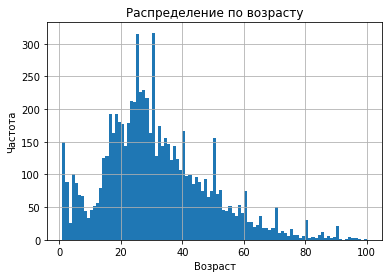

In [4]:
bins = labels['real_age'].max() - labels['real_age'].min()
labels['real_age'].hist(bins=bins)
plt.xlabel('Возраст')
plt.ylabel('Частота')
plt.title('Распределение по возрасту')
plt.show()

Распределение смещено вправо. Имеются выбросы на округлённых возрастах - 25, 30, 40, 50 и т.д. лет.  Так же в представленном датасете имеется второй пик распределения в возрасте до 10 лет. И даже 149 фотографий, размеченных как "1 год отроду". Весьма странная аудитория для сетевого супермакета - такие клиенты самостоятельностью не отличаются. Так же достаточно малочисленно представлена возрастная категория 60+, в условиях недостатка данных модель может нагло врать.   
Распределение в цифрах:

In [5]:
labels.describe()

,real_age
count,7591.000000
mean,31.201159
std,17.145060
min,1.000000
25%,20.000000
50%,29.000000
75%,41.000000
max,100.000000


Средний возраст - 31 год, медианный - 29 лет. Межквартильный интервал от 20 лет до 41 года. 

И взглянем на несколько фотографий. 

In [6]:
train_datagen = ImageDataGenerator(rescale=1./255)
train_datagen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345) 

Found 7591 validated image filenames.


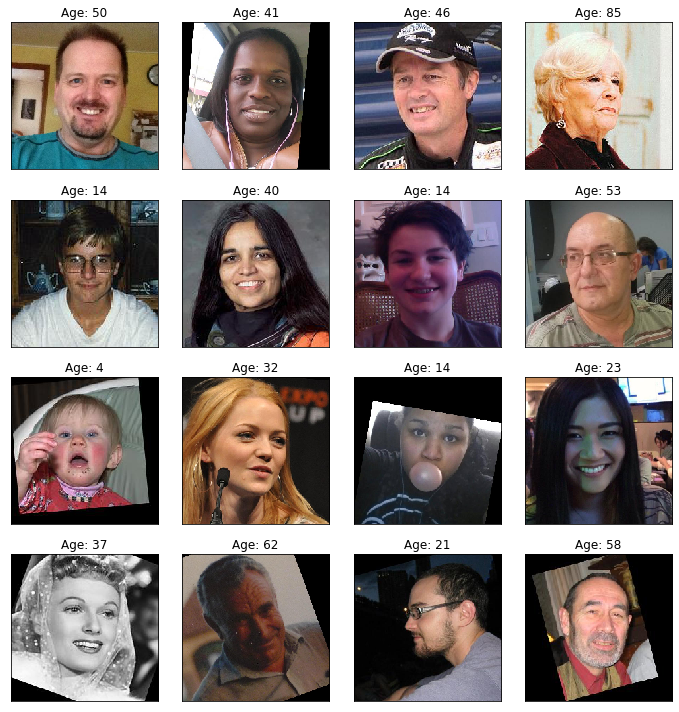

In [7]:
features, target = next(train_datagen_flow)
fig = plt.figure(figsize=(10,10))
for i in range(16):
    fig.add_subplot(4, 4, i+1)
    plt.imshow(features[i])
    plt.title(f'Age: {target[i]}')
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

Что можно сказать? На фотографиях люди. Разные люди. Разных возрастов, но, похоже, размечены правильно, хотя глядя на человека можно точно оценить его возраст. Кроме того, фотографии в разных ситуациях и иногда не лучшего качества. Встречаются как цветные, так и чёрно-белые фотографии, некоторые из них являются отсканированными копиями, иные - фотографии с веб-камер. Встречаются и кадры из кино. Присутствуют как изображения бытовых ситуаций, так и официальные фотографии; профессиональные и любительские; аналогвые и цифровые. Угол поворота изображений не всегда прямой, причём со странной кривой обрезкой. Весьма и весьма разнообразная подборка. Непростая задача. Быть может машина с ней справится. 

## Обучение модели

Для данной задачи будем использовать нейронную сеть ReNet50. Так как в базовой постановке она собрана для задачи классификации, то пересоберём выходной слой для задачи регрессии - оставим один нейрон без функции активации.  
Код представляет собой 4 функции, предназначенные для запуска на GPU-тренажёре. 

```python

from tensorflow.keras import Sequential
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pandas as pd
from tensorflow.keras.optimizers import Adam

def load_train(path):
    '''Загрузка обучающих данных'''
    try:
        labels = pd.read_csv(path+'labels.csv')
        train_datagen = ImageDataGenerator(rescale=1./255,
                                           validation_split=0.25,
                                           horizontal_flip=True,
                                           )
        train_datagen_flow = train_datagen.flow_from_dataframe(
                dataframe=labels,
                directory=path+'final_files/',
                x_col='file_name',
                y_col='real_age',
                target_size=(224, 224),
                batch_size=32,
                class_mode='raw',
                subset='training',
                seed=12345)
      
        return train_datagen_flow
    
    except Exception as Ex:
        print(Ex)

def load_test(path):
    '''Загрузка тестовых данных'''
    try:
        labels = pd.read_csv(path+'labels.csv')
        test_datagen = ImageDataGenerator(rescale=1./255,
                                          validation_split=0.25)
        test_datagen_flow = test_datagen.flow_from_dataframe(
                dataframe=labels,
                directory=path+'final_files/',
                x_col='file_name',
                y_col='real_age',
                target_size=(224, 224),
                batch_size=32,
                class_mode='raw',
                subset='validation',
                seed=12345)
        
        return test_datagen_flow
    
    except Exception as Ex:
        print(Ex)

def create_model(input_shape):
    '''Создание модели'''
    try:
        optimizer = Adam(lr=0.00005)
    
        backbone = ResNet50(input_shape=input_shape,
                            include_top=False)
        model = Sequential()
        model.add(backbone)
        model.add(GlobalAveragePooling2D())
        model.add(Dense(1, activation='relu'))
        model.compile(optimizer=optimizer, loss='mean_absolute_error',
                      metrics=['mae'])
     
        return model
    
    except Exception as Ex:
        print(Ex)

def train_model(model, train_data, test_data, batch_size=None, epochs=40,
               steps_per_epoch=None, validation_steps=None):
    '''Обучение модели'''
    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)
        
    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size,
              epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2, shuffle=True)

    return model 

```

Результат работы кода - копия из консоли: 

```
Train for 178 steps, validate for 60 steps
Epoch 1/40
2021-09-02 08:39:15.647244: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2021-09-02 08:39:15.960572: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
178/178 - 46s - loss: 14.0627 - mae: 14.0644 - val_loss: 24.7338 - val_mae: 24.7445
Epoch 2/40
178/178 - 38s - loss: 7.4306 - mae: 7.4306 - val_loss: 22.6982 - val_mae: 22.7083
Epoch 3/40
178/178 - 38s - loss: 6.1759 - mae: 6.1763 - val_loss: 17.8883 - val_mae: 17.8619
Epoch 4/40
178/178 - 38s - loss: 5.4110 - mae: 5.4114 - val_loss: 8.3863 - val_mae: 8.3694
Epoch 5/40
178/178 - 38s - loss: 4.9188 - mae: 4.9191 - val_loss: 6.7204 - val_mae: 6.7205
Epoch 6/40
178/178 - 38s - loss: 4.4373 - mae: 4.4378 - val_loss: 6.4198 - val_mae: 6.4123
Epoch 7/40
178/178 - 38s - loss: 4.1743 - mae: 4.1747 - val_loss: 7.5373 - val_mae: 7.5223
Epoch 8/40
178/178 - 38s - loss: 3.8612 - mae: 3.8612 - val_loss: 6.0377 - val_mae: 6.0508
Epoch 9/40
178/178 - 38s - loss: 3.6588 - mae: 3.6589 - val_loss: 6.4431 - val_mae: 6.4324
Epoch 10/40
178/178 - 38s - loss: 3.3703 - mae: 3.3704 - val_loss: 5.9625 - val_mae: 5.9665
Epoch 11/40
178/178 - 38s - loss: 3.1419 - mae: 3.1419 - val_loss: 5.8105 - val_mae: 5.8465
Epoch 12/40
178/178 - 38s - loss: 3.0578 - mae: 3.0579 - val_loss: 6.1903 - val_mae: 6.2161
Epoch 13/40
178/178 - 38s - loss: 2.8487 - mae: 2.8488 - val_loss: 5.9297 - val_mae: 5.9411
Epoch 14/40
178/178 - 37s - loss: 2.7021 - mae: 2.7024 - val_loss: 5.9222 - val_mae: 5.9374
Epoch 15/40
178/178 - 37s - loss: 2.5960 - mae: 2.5959 - val_loss: 5.6958 - val_mae: 5.7186
Epoch 16/40
178/178 - 38s - loss: 2.5009 - mae: 2.5011 - val_loss: 5.7861 - val_mae: 5.8007
Epoch 17/40
178/178 - 38s - loss: 2.2986 - mae: 2.2985 - val_loss: 5.6273 - val_mae: 5.6434
Epoch 18/40
178/178 - 39s - loss: 2.3111 - mae: 2.3111 - val_loss: 6.2168 - val_mae: 6.2188
Epoch 19/40
178/178 - 39s - loss: 2.2441 - mae: 2.2443 - val_loss: 5.7624 - val_mae: 5.7910
Epoch 20/40
178/178 - 38s - loss: 2.1360 - mae: 2.1359 - val_loss: 6.0415 - val_mae: 6.0757
Epoch 21/40
178/178 - 38s - loss: 2.1318 - mae: 2.1317 - val_loss: 5.6099 - val_mae: 5.6155
Epoch 22/40
178/178 - 38s - loss: 2.0428 - mae: 2.0430 - val_loss: 5.9141 - val_mae: 5.9201
Epoch 23/40
178/178 - 39s - loss: 2.0660 - mae: 2.0662 - val_loss: 5.6008 - val_mae: 5.6101
Epoch 24/40
178/178 - 39s - loss: 1.9579 - mae: 1.9580 - val_loss: 5.6732 - val_mae: 5.6815
Epoch 25/40
178/178 - 38s - loss: 1.8909 - mae: 1.8910 - val_loss: 5.7381 - val_mae: 5.7484
Epoch 26/40
178/178 - 38s - loss: 1.8518 - mae: 1.8519 - val_loss: 5.6448 - val_mae: 5.6616
Epoch 27/40
178/178 - 39s - loss: 1.8460 - mae: 1.8458 - val_loss: 5.6322 - val_mae: 5.6466
Epoch 28/40
178/178 - 38s - loss: 1.7987 - mae: 1.7987 - val_loss: 5.7837 - val_mae: 5.8157
Epoch 29/40
178/178 - 39s - loss: 1.7815 - mae: 1.7815 - val_loss: 5.8192 - val_mae: 5.8299
Epoch 30/40
178/178 - 38s - loss: 1.7380 - mae: 1.7380 - val_loss: 5.8095 - val_mae: 5.8287
Epoch 31/40
178/178 - 38s - loss: 1.7415 - mae: 1.7414 - val_loss: 5.9350 - val_mae: 5.9637
Epoch 32/40
178/178 - 38s - loss: 1.7223 - mae: 1.7223 - val_loss: 6.0801 - val_mae: 6.1034
Epoch 33/40
178/178 - 39s - loss: 1.6680 - mae: 1.6680 - val_loss: 5.6599 - val_mae: 5.6872
Epoch 34/40
178/178 - 38s - loss: 1.6627 - mae: 1.6626 - val_loss: 5.5749 - val_mae: 5.5928
Epoch 35/40
178/178 - 38s - loss: 1.6211 - mae: 1.6213 - val_loss: 5.5921 - val_mae: 5.6020
Epoch 36/40
178/178 - 39s - loss: 1.6324 - mae: 1.6324 - val_loss: 5.5288 - val_mae: 5.5578
Epoch 37/40
178/178 - 38s - loss: 1.5788 - mae: 1.5788 - val_loss: 5.6697 - val_mae: 5.6779
Epoch 38/40
178/178 - 38s - loss: 1.5760 - mae: 1.5759 - val_loss: 5.6340 - val_mae: 5.6528
Epoch 39/40
178/178 - 39s - loss: 1.5579 - mae: 1.5580 - val_loss: 5.5889 - val_mae: 5.6028
Epoch 40/40
178/178 - 38s - loss: 1.5310 - mae: 1.5310 - val_loss: 5.5249 - val_mae: 5.5388

WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']

60/60 - 9s - loss: 5.5249 - mae: 5.5388
Test MAE: 5.5388

```

## Анализ обученной модели

Обучение модели было выполнено на 40 эпохах. Минимизация функции потерь осуществлялось алгоритмом Adam с шагом обучения 0.00005. Модель заметно переобучилась - на последнем шаге метрика MAE на обучающей выборке ~1.53, а на тестовой - ~5.5. Финальный результат - MAE=5.5388, что удовлетворяет техническому заданию. 

## Заключение

1. Проведён исследовательский анализ имеющейся выборки фотографий. Средний возраст людей на них - 31 год. Большинство фотографий принадлежит людям в возрасте от 20 до 41 года. Возрастная группа 60+ представлена слабо, поэтому модель там может сильно ошибаться. Много фотографий маленьких детей, вероятность появления которых без сопровождения взрослых в нашем супермаркете мала.  
2. Обученная нейронная сеть при распознавании возраста по фотографии показывает среднюю абсолютную ошибку в 6 лет. Для системы рекомендации товара по возрастным группам такая точность подойдёт. Но для продажи алкоголя такой точности явно не достаточно. Старое доброе распознавание возраста по паспорту - куда более надёжное средство. К тому же кассиры и без того неплохо обучены и требуют документы при любом подозрении. 
3. Сделать предсказания точнее поможет расширенный и более сбалансированный датасет. 